# Data Scientist Professional Case Study

### Company Background

Tasty Bytes , an online recipe startup, has hired you as a data scientist. The website features new recipes on the homepage every day. The owner has told you that on days that they feature a popular recipe, traffic increases by as much as 40%. However, it is difficult to predict in advance which recipes will be popular.

Recipes are considered to be popular if they receive a high score. The data team has collected data from previously published recipes.



### Customer Question

The owner wants to know:
- Can you use information on previously published recipes to predict whether a recipe will receive a high score?




### Success Criteria

The owner estimates that of all low scoring recipes, they currently correctly categorize 75% of them. They want to know how your approach compares to this.


### Dataset

The data you will use for this analysis can be accessed here: `"data/recipes.csv"`

In [3]:
# Skopt for hyperparameter tuning
!pip install scikit-optimize --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
awscli 1.19.53 requires PyYAML<5.5,>=3.10, but you have pyyaml 6.0 which is incompatible.
pythonwhat 2.23.1 requires dill~=0.2.7.1, but you have dill 0.3.3 which is incompatible.
pythonwhat 2.23.1 requires jinja2~=2.10, but you have jinja2 3.0.1 which is incompatible.


In [4]:
# Import prerequisities
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import difflib
from scipy.stats import t
from scipy.stats import loguniform
from IPython.display import display
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [5]:
# Check the preview of the data
df = pd.read_csv("data/recipes.csv")
df.head(2)

,RecipeId,Name,RecipeCategory,Calories,CholesterolContent,CarbohydrateContent,SugarContent,ProteinContent,RecipeServings,HighScore
0,46085,Crock Pot Baked Potato Soup,One Dish Meal,699.8,137.3,46.1,1.4,20.9,6.0,1.0
1,93832,Frittata Di Spaghetti (spaghetti Frittata),Breakfast,297.1,191.8,11.7,0.7,12.2,8.0,1.0


In [6]:
# Describe the data
df.describe()

,RecipeId,Calories,CholesterolContent,CarbohydrateContent,SugarContent,ProteinContent,RecipeServings,HighScore
count,43092.000000,43092.000000,43092.000000,43092.000000,43092.000000,43092.000000,43092.000000,43092.000000
mean,224707.928154,353.297587,69.475757,32.844187,12.206600,15.773125,9.517521,0.645735
std,141980.914350,405.065683,112.422309,46.428258,28.304371,21.588594,224.022873,0.478296
min,38.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,102616.750000,164.800000,4.500000,11.600000,2.200000,3.400000,4.000000,0.000000
50%,212333.000000,284.100000,40.700000,25.400000,5.500000,8.800000,6.000000,1.000000
75%,336736.250000,446.725000,95.900000,43.400000,14.100000,24.300000,8.000000,1.000000
max,540876.000000,30933.400000,9167.200000,3564.400000,2566.800000,1420.800000,32767.000000,1.000000


In [7]:
# HighScore is a binary value consisting 1 and 0, so we'll perform classification
df["HighScore"].unique()

array([1., 0.])

In [8]:
# "RecipeId" might be useless, cause it contains all unique values
# For "Name", it contains many unique values, but we'll analyze whether there are similiriaty between name in "Name"
print(df.shape[0], df.RecipeId.nunique())
print(df.shape[0], df.Name.nunique())
print(df.shape[0], df.RecipeCategory.nunique())

43092 43092
43092 41240
43092 246


In [9]:
# Drop recipe id
df.drop('RecipeId', axis=1, inplace=True)

In [10]:
# Check if there are similiarity between text on "Name" columns

np.random.seed(123)
# Drop duplicate to prevent similiarity with the same name
# Use sampling to 1000 to fasten time
tmp = df.Name.drop_duplicates(keep='first').sample(1000, replace=False)

same=0
dictionary={}
for txt in tmp:
    i = difflib.get_close_matches(txt, tmp, cutoff=0.7)[1:]
    same+=len(i)
    dictionary[txt] = i

In [11]:
# It turns out 11% of the name from sample has similiarity with other texts
# If we increase the number of sample to 2000, turns out 25% has similiarity with other texts
# "Name" columns might help in further analysis
print(round(same/1000*100,2),'%')

11.2 %


In [12]:
# Example of similar text
tmp_dict = dict(filter(lambda x: len(x[1]) > 0, dictionary.items()))
print('Filtered Dictionary : ')
pd.DataFrame.from_dict(tmp_dict, orient='index', columns=['first','second']).fillna('-').sort_values(by='second',ascending=False)

Filtered Dictionary : 


,first,second
Cherry Chocolate Cake,Cherry Chocolate Chip Ice Cream,Sourdough Chocolate Cake
Pork Chops With Mustard Sauce,Pork Chops With Caramelized Orange Sauce,Pork Tenderloin With Garlic Mustard Sauce
Peanut Butter Cup Bars,Peanut Butter Fingers,Peanut Butter Swirl Brownies
Peanut Butter Swirl Brownies,Peanut Butter Fingers,Peanut Butter Cup Bars
Bistro Burgers,Brew Burgers,Onion Burgers
...,...,...
Mushroom Ragu,Mushroom Curry,-
Garlic Chicken Breasts,Grilled Marinated Chicken Breasts,-
Baked Herbed Chicken Breast,Grilled Marinated Chicken Breasts,-
"Shrimp, mango and pasta salad",Shrimp and Pasta Salad,-


In [13]:
# There are 2 rows that is duplicated
df[df.duplicated(keep=False)]

,Name,RecipeCategory,Calories,CholesterolContent,CarbohydrateContent,SugarContent,ProteinContent,RecipeServings,HighScore
9182,Pockets of Lemon Cake,Dessert,228.7,0.0,28.8,21.1,2.5,16.0,1.0
10523,Pockets of Lemon Cake,Dessert,228.7,0.0,28.8,21.1,2.5,16.0,1.0
21427,Greek-Style Chicken Casserole,Chicken Thigh & Leg,701.0,189.3,35.2,10.5,44.4,4.0,1.0
22004,Greek-Style Chicken Casserole,Chicken Thigh & Leg,701.0,189.3,35.2,10.5,44.4,4.0,1.0


In [14]:
# Drop the duplicate row
df.drop_duplicates(keep='first', inplace=True)

In [15]:
# Check if there are duplicated name and recipe category
df[df.duplicated(subset=['Name','RecipeCategory'], keep=False)].sort_values(by='Name')[:6]
# No need to drop because the numeric features are various although the name and recipe category are the same

,Name,RecipeCategory,Calories,CholesterolContent,CarbohydrateContent,SugarContent,ProteinContent,RecipeServings,HighScore
22234,5 Minute Chocolate Cake,Dessert,398.5,109.0,41.3,25.5,6.6,2.0,0.0
41339,5 Minute Chocolate Cake,Dessert,844.2,217.9,86.2,51.9,12.6,1.0,0.0
6245,African Banana Peanut Cake,Dessert,567.1,87.2,64.6,28.4,12.4,8.0,1.0
16043,African Banana Peanut Cake,Dessert,495.0,86.8,59.4,26.8,10.3,8.0,1.0
13305,Almond French Toast,Breakfast,390.9,186.9,31.2,3.5,13.8,16.0,1.0
32107,Almond French Toast,Breakfast,513.5,221.1,34.2,6.4,13.2,4.0,1.0


In [16]:
# There are 40 missing values in RecipeCategory
df.isnull().sum()

Name                    0
RecipeCategory         40
Calories                0
CholesterolContent      0
CarbohydrateContent     0
SugarContent            0
ProteinContent          0
RecipeServings          0
HighScore               0
dtype: int64

In [17]:
# We could extract recipe category from the similar "Name" that has "RecipeCategory"
df[df.RecipeCategory.isnull()].head()

,Name,RecipeCategory,Calories,CholesterolContent,CarbohydrateContent,SugarContent,ProteinContent,RecipeServings,HighScore
365,Cheesy Vegetable Pasta,NaN,387.0,22.1,48.5,4.4,16.4,4.0,1.0
1449,Southwestern Black Beans and Barley,NaN,370.6,0.0,71.2,3.7,19.3,6.0,1.0
4460,Slow Cooker Osso Buco,NaN,199.6,15.3,22.1,5.1,4.1,4.0,1.0
6134,French Onion Soup: the Cook's Illustrated Way,NaN,727.0,34.9,114.2,11.7,31.6,6.0,1.0
6522,Spicy Two-Bean Chili,NaN,383.6,56.1,38.3,3.9,27.1,11.0,1.0


In [18]:
# Find the first most similar text (index 1 not 0) that coresspond to missing category

# impute = []
# for i,j in df[df.RecipeCategory.isnull()].Name.iteritems():
#     similar_text = difflib.get_close_matches(j, df.Name, cutoff=0.5)[1]
#     tmp = df[df['Name']==similar_text]['RecipeCategory']
#     impute.append((i, tmp.values[0]))
    
# The results of imputed category. They're assigned to list because the running time is quite long 
impute = [(365, 'Vegetable'), (1449, 'Black Beans'), (4460, 'Pork'), (6134, 'Clear Soup'), (6522, 'Lamb/Sheep'), (7342, 'Meat'), (7847, 'Vegetable'), (8816, 'Vegetable'), (10398, 'One Dish Meal'), (11781, 'Weeknight'), (11847, 'Spreads'), (11946, 'Lunch/Snacks'), (12510, 'Breakfast'), (13669, 'Pork'), (15020, 'Chicken Breast'), (15576, 'One Dish Meal'), (16426, 'One Dish Meal'), (16644, 'Chicken'), (18844, 'Curries'), (19329, 'Vegetable'), (20575, 'Beans'), (20915, 'Grains'), (22394, 'Breads'), (22759, 'Clear Soup'), (23308, 'One Dish Meal'), (24981, 'Spicy'), (25547, 'One Dish Meal'), (25605, 'One Dish Meal'), (28251, 'One Dish Meal'), (29441, 'Meat'), (30138, 'Pork'), (30178, 'Pork'), (33078, 'One Dish Meal'), (33103, 'Stew'),
 (35041, 'Steak'), (35848, 'Chicken'), (36467, 'Very Low Carbs'), (36955, 'Lunch/Snacks'), (38682, 'Breakfast'), (41001, 'Chicken Breast')]

In [19]:
# Impute the missing value
for i,j in impute:
    df.loc[i,'RecipeCategory']=j
    
# Check the null sum
df.isnull().sum().sum()

0

In [20]:
# We can drop "Name" columns because we won't need it anymore in the prediction
df.drop("Name", axis=1, inplace=True)

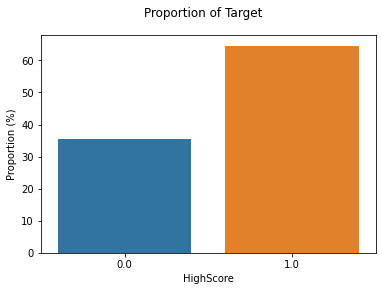

In [21]:
# If we look on the target, the target is not too imbalanced
# No need to up/down sampling, we can instead use model that treat target in different weight (gradient boosting model)
tmp_df = df.HighScore.\
         value_counts(normalize=True).\
         rename('percentage').\
         mul(100)

sns.barplot(tmp_df.index, tmp_df.values)
plt.suptitle("Proportion of Target")
plt.xlabel("HighScore")
plt.ylabel("Proportion (%)");

In [22]:
# Check the highscore proportion of each category that is equal to 1
tmp1= df.groupby('RecipeCategory')['HighScore'].sum().sort_index()
tmp2= df.RecipeCategory.value_counts().sort_index()
prop_category = (tmp1/tmp2*100).sort_values(ascending=False)

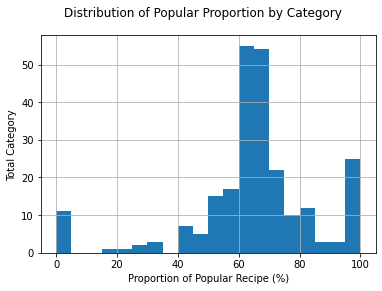

In [23]:
# Plot the distribution
prop_category.hist(bins=20)
plt.suptitle("Distribution of Popular Proportion by Category")
plt.xlabel("Proportion of Popular Recipe (%)")
plt.ylabel("Total Category");

# There are more than 100 categories that has 60-70% highscore proportion equal to 1

In [24]:
# There are also 25 categories that always popular
print(prop_category[prop_category==100].count())
prop_category[prop_category==100].index

25


Index(['Polish', 'St. Patrick's Day', 'Quail', 'Pumpkin', 'Puerto Rican',
       'Polynesian', 'High Fiber', 'Pennsylvania Dutch', 'Papaya', 'Colombian',
       'No Shell Fish', 'Desserts Fruit', 'New Zealand', 'Native American',
       'Mixer', 'Macaroni And Cheese', 'Indonesian', 'Cambodian', 'Hawaiian',
       'Whole Duck', 'Stove Top', 'Sudanese', 'Artichoke', 'Avocado', 'Welsh'],
      dtype='object', name='RecipeCategory')

In [25]:
# Divide every recipe ingredients by the recipe servings (each ingredient for 1 servings)
for i in ['Calories','CholesterolContent','CarbohydrateContent',
    	  'SugarContent','ProteinContent']:
	df[i] = df[i]/df.RecipeServings

In [26]:
# Encode the categorical columns with label encoder
le = LabelEncoder()
df['RecipeCategory'] = le.fit_transform(df['RecipeCategory']).astype(str)

In [27]:
# Split dataframe to train and test, test should not be concluded in further analysis
df, df_test = train_test_split(df, test_size=0.1, stratify=df['HighScore'])

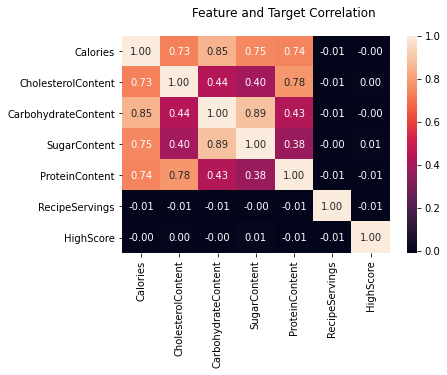

In [28]:
# Check the correlation between each feature and target
sns.heatmap(df.iloc[:,1:].corr(), annot=True, fmt='.2f')
plt.suptitle("Feature and Target Correlation");

# There are some multicolinearity between feature, tree based model could overcome it
# We can't conclude the HighScore relationship with pearson, we'll try another way

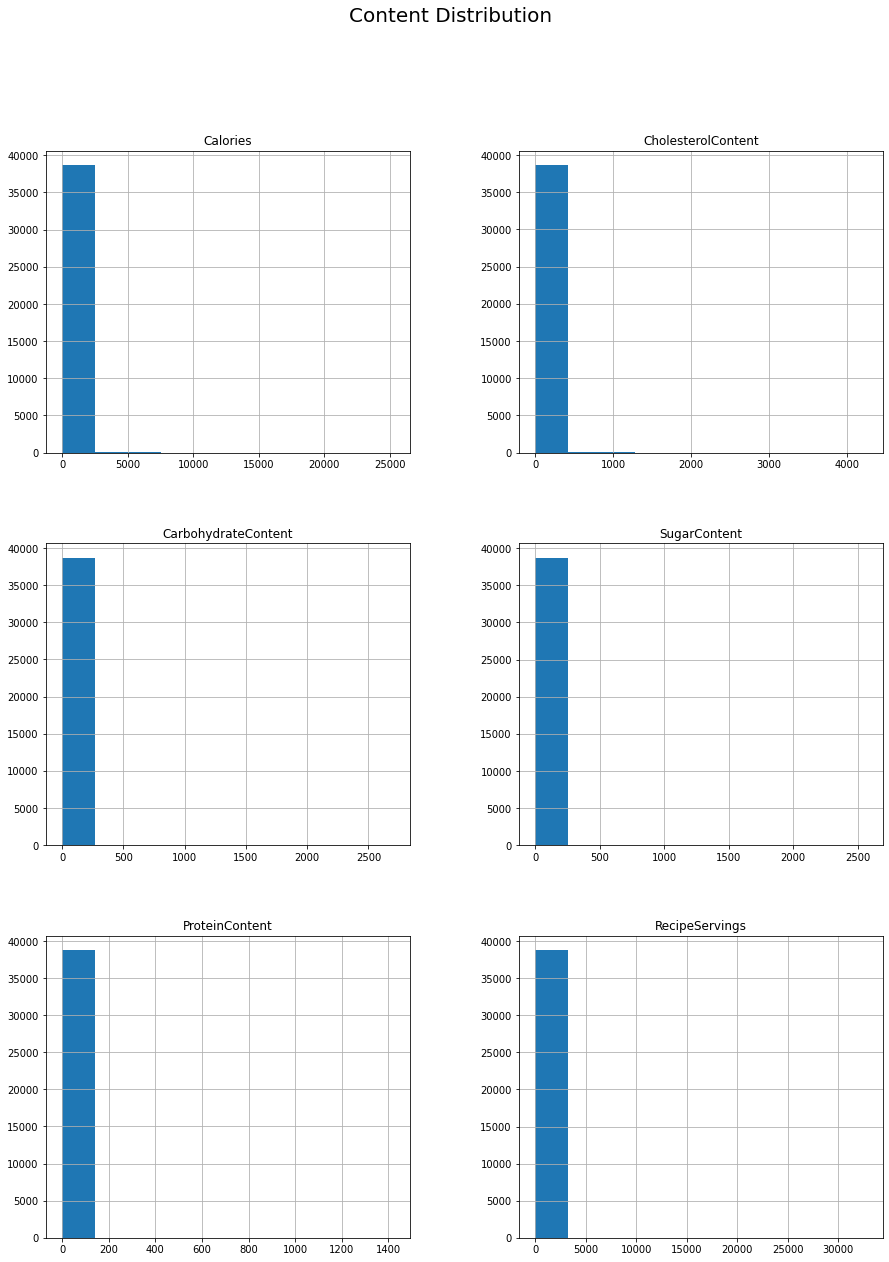

In [29]:
# The distribution of the ingredients are very skewed due to extreme outlier
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
df.iloc[:,1:-1].hist(ax = ax)
plt.suptitle("Content Distribution", fontsize=20);

In [30]:
# If we check the 99% data has big difference with the max value

print(f"Max Calories:{df.Calories.max()}\n99% Calories:{round(np.quantile(df.Calories,0.99),2)}", end='\n\n')

print(f"Max Sugar:{df.SugarContent.max()}\n99% Sugar:{round(np.quantile(df.SugarContent,0.99),2)}", end='\n\n')

print(f"Max Cholesterol:{df.CholesterolContent.max()}\n99% Cholesterol:{round(np.quantile(df.CholesterolContent,0.99),2)}", end='\n\n')

print(f"Max Carbohydrate:{df.CarbohydrateContent.max()}\n99% Carbohydrate:{round(np.quantile(df.CarbohydrateContent,0.99),2)}", end='\n\n')

print(f"Max Protein:{df.ProteinContent.max()}\n99% Protein:{round(np.quantile(df.ProteinContent,0.99),2)}", end='\n\n')

Max Calories:25248.7
99% Calories:679.82

Max Sugar:2566.8
99% Sugar:33.52

Max Cholesterol:4251.1
99% Cholesterol:201.73

Max Carbohydrate:2700.9
99% Carbohydrate:71.2

Max Protein:1420.8
99% Protein:30.7



In [31]:
# We want to see the distribution without the outlier
# We will filter the data that is on 99% below
dict_tmp = {}

for i,j in [(df,'train')]:
  dict_tmp[j] = i[(i.SugarContent < np.quantile(df.SugarContent,0.99))&
           	(i.CarbohydrateContent < np.quantile(df.CarbohydrateContent,0.99))&
           	(i.ProteinContent < np.quantile(df.ProteinContent,0.99))&
           	(i.Calories < np.quantile(df.Calories,0.99))&
           	(i.CholesterolContent < np.quantile(df.CholesterolContent,0.99))&
            (i.RecipeServings < np.quantile(df.RecipeServings,0.99))]

# Remove the outlier
filter_df = dict_tmp['train']

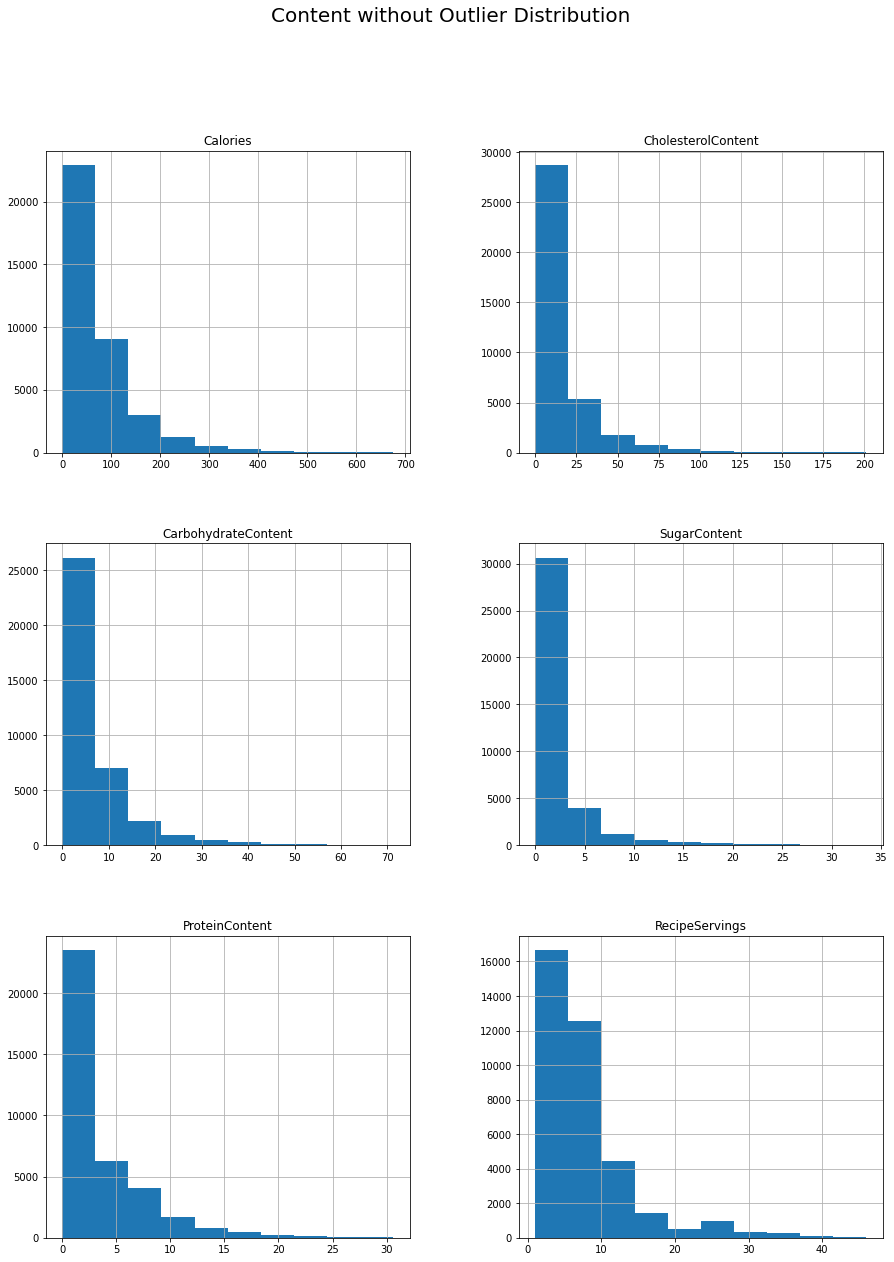

In [32]:
# We could see the distribution is right skewed
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
filter_df.iloc[:,1:-1].hist(ax = ax)
plt.suptitle("Content without Outlier Distribution", fontsize=20);

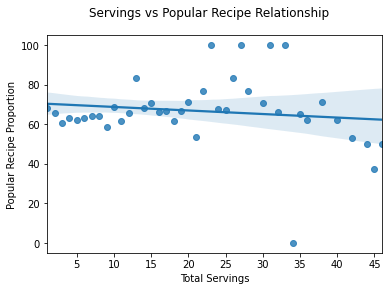

In [33]:
# Check the highscore proportion of each category that is equal to 1
temp1= filter_df.groupby('RecipeServings')['HighScore'].sum().sort_index()
temp2= filter_df.RecipeServings.value_counts().sort_index()
prop_serving = (temp1/temp2*100)
sns.regplot(prop_serving.index, prop_serving.values);
plt.xlabel("Total Servings")
plt.ylabel("Popular Recipe Proportion")
plt.suptitle("Servings vs Popular Recipe Relationship");

In [34]:
# There are some corrupted data (the content and calories are nearly zero and zero), we can't get any information with this
tmp = filter_df[(filter_df.SugarContent <= np.quantile(df.SugarContent,0.01))&
           (filter_df.CarbohydrateContent<=np.quantile(df.CarbohydrateContent,0.01))&
           	(filter_df.ProteinContent <= np.quantile(df.ProteinContent,0.01))&
           	(filter_df.Calories <= np.quantile(df.Calories,0.01))&
           	(filter_df.CholesterolContent<=np.quantile(df.CholesterolContent,0.01))]
print("Recipe Popularity with All Content around 0", end='')
tmp.HighScore.value_counts()
# The proportion is pretty much too

Recipe Popularity with All Content around 0

1.0    134
0.0     44
Name: HighScore, dtype: int64

In [35]:
# We'll remove this to reduce bias

dict_tmp = {}

for i,j in [(filter_df,'train')]:
  dict_tmp[j] = i[~((i.SugarContent <= np.quantile(df.SugarContent,0.01))&
           	(i.CarbohydrateContent<=np.quantile(df.CarbohydrateContent,0.01))&
           	(i.ProteinContent <= np.quantile(df.ProteinContent,0.01))&
           	(i.Calories <= np.quantile(df.Calories,0.01))&
           	(i.CholesterolContent<=np.quantile(df.CholesterolContent,0.01)))]

# Remove corrupted data
filter_df = dict_tmp['train']

In [36]:
# Check the popularity proportion if each content is 0

print("Populariy proportion when each content is 0")
display(filter_df[(filter_df.SugarContent ==  0)].HighScore.value_counts(normalize=True).rename("SugarContent"))
display(filter_df[(filter_df.CarbohydrateContent ==  0)].HighScore.value_counts(normalize=True).rename("CarbohydrateContent"))
display(filter_df[(filter_df.ProteinContent ==  0)].HighScore.value_counts(normalize=True).rename("ProteinContent"))
display(filter_df[(filter_df.CholesterolContent ==  0)].HighScore.value_counts(normalize=True).rename("CholesterolContent"))

Populariy proportion when each content is 0


1.0    0.679675
0.0    0.320325
Name: SugarContent, dtype: float64

1.0    0.707865
0.0    0.292135
Name: CarbohydrateContent, dtype: float64

1.0    0.706522
0.0    0.293478
Name: ProteinContent, dtype: float64

1.0    0.654662
0.0    0.345338
Name: CholesterolContent, dtype: float64

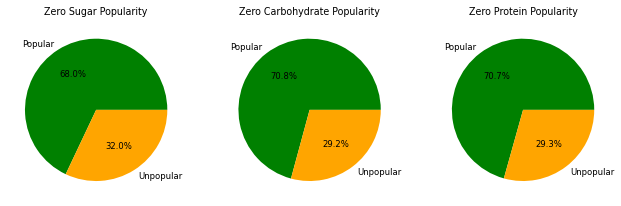

In [37]:
# Pie plot the composition of zero ingredient popularity
fig, ax = plt.subplots(1,3)

ax[0].set_title("Zero Sugar Popularity", fontsize=9.5) 
ax[0].pie(filter_df[(filter_df.SugarContent ==  0)].HighScore.value_counts(normalize=True).rename("SugarContent"), labels=['Popular','Unpopular'], autopct='%1.1f%%', colors=['green','orange'],textprops={'fontsize': 8.5})

ax[1].set_title("Zero Carbohydrate Popularity", fontsize=9.5) 
ax[1].pie(filter_df[(filter_df.CarbohydrateContent ==  0)].HighScore.value_counts(normalize=True).rename("CarbohydrateContent"), labels=['Popular','Unpopular'], autopct='%1.1f%%', colors=['green','orange'],textprops={'fontsize': 8.5})

ax[2].set_title("Zero Protein Popularity", fontsize=9.5) 
ax[2].pie(filter_df[(filter_df.ProteinContent ==  0)].HighScore.value_counts(normalize=True).rename("ProteinContent"), labels=['Popular','Unpopular'], autopct='%1.1f%%', colors=['green','orange'],textprops={'fontsize': 8.5})

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=1.5, 
                    top=0.9);

In [38]:
# Made a second dataframe where data is being log-transformed
log_df = filter_df.copy()
log_df.iloc[:,1:-1] = log_df.iloc[:,1:-1].apply(lambda x: np.log(x+0.01))
log_df_test = df_test.copy()
log_df_test.iloc[:,1:-1] = log_df_test.iloc[:,1:-1].apply(lambda x: np.log(x+0.01))

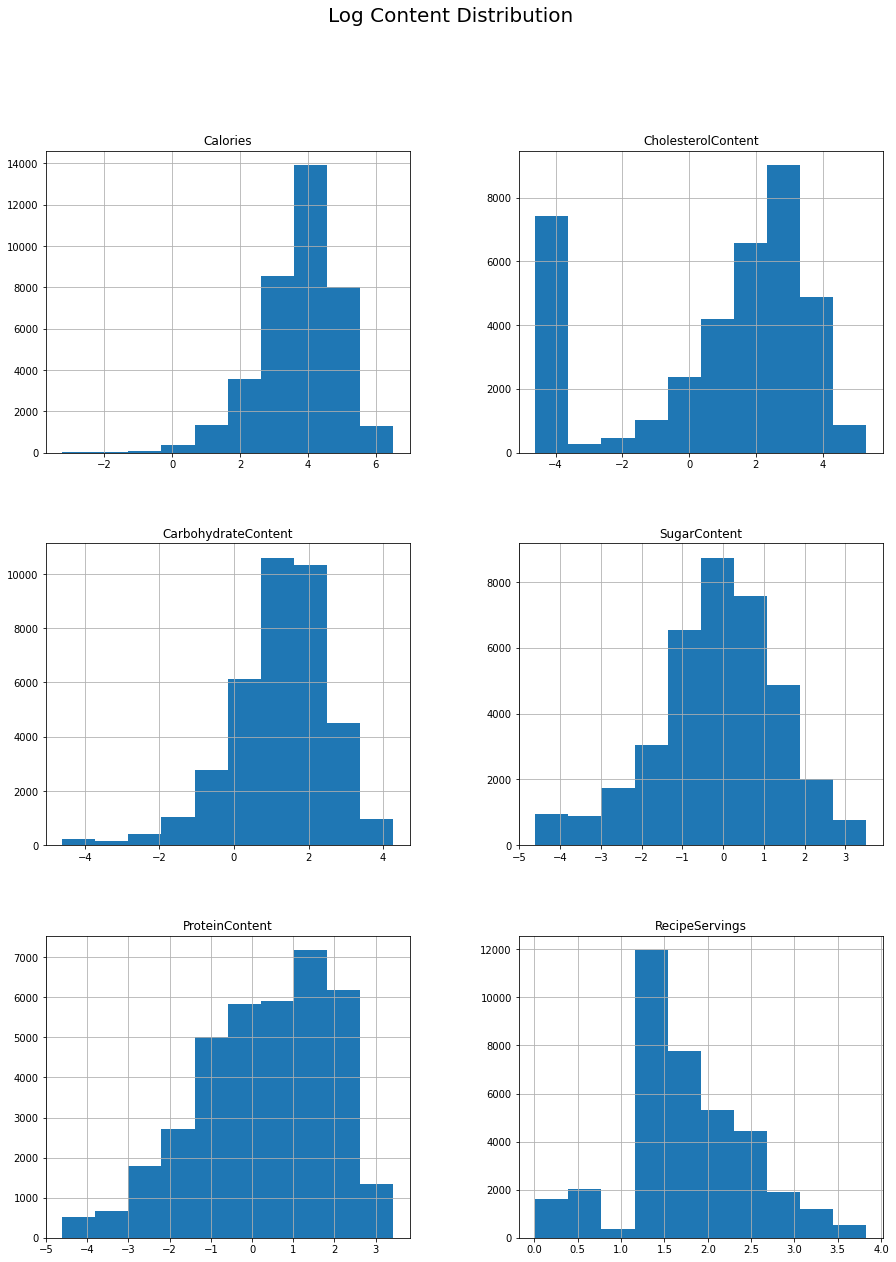

In [39]:
# The distribution is better, approaching the normal distribution
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
log_df.iloc[:,1:-1].hist(ax = ax)
plt.suptitle("Log Content Distribution", fontsize=20);

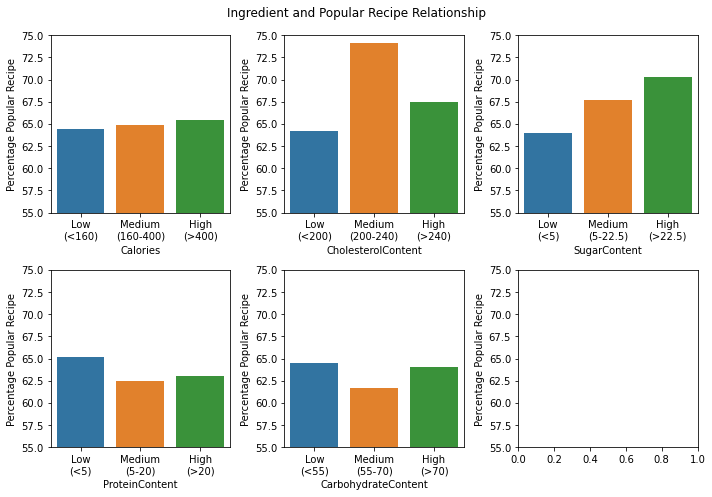

In [40]:
# Checking the effect of each ingredients with popular recipe proportions

fig,ax = plt.subplots(2,3, figsize=(10,7))
for i in ax:
    for j in i:
        j.set_ylim([55,75])

plt.suptitle("Ingredient and Popular Recipe Relationship")

tmp =df[~((df.SugarContent <= np.quantile(df.SugarContent,0.01))&
           	(df.CarbohydrateContent<=np.quantile(df.CarbohydrateContent,0.01))&
           	(df.ProteinContent <= np.quantile(df.ProteinContent,0.01))&
           	(df.Calories <= np.quantile(df.Calories,0.01))&
           	(df.CholesterolContent<=np.quantile(df.CholesterolContent,0.01)))]

# https://eatiquette.io/calorie-density/
cal_cat = pd.concat([pd.cut(x=tmp['Calories'], bins=[0, 160, 400, 30000], labels=['Low\n(<160)','Medium\n(160-400)',"High\n(>400)"]),tmp['HighScore']], axis=1)
cal_group = pd.DataFrame(cal_cat.groupby('Calories')['HighScore'].sum()/cal_cat['Calories'].value_counts()*100).round(2).reset_index()
sns.barplot(cal_group['Calories'],cal_group[0], ax=ax[0,0])

# https://www.verywellhealth.com/what-is-a-total-cholesterol-level-698073
col_cat = pd.concat([pd.cut(x=tmp['CholesterolContent'], bins=[0, 200, 240, 5000], labels=['Low\n(<200)','Medium\n(200-240)',"High\n(>240)"]),tmp['HighScore']], axis=1)
col_group = pd.DataFrame(col_cat.groupby('CholesterolContent')['HighScore'].sum()/col_cat['CholesterolContent'].value_counts()*100).round(2)
col_group.index.name = "CholesterolContent"
sns.barplot(col_group.reset_index()['CholesterolContent'],col_group.reset_index()[0], ax=ax[0,1])

# https://www.nhs.uk/live-well/eat-well/food-types/how-does-sugar-in-our-diet-affect-our-health/
sug_cat = pd.concat([pd.cut(x=tmp['SugarContent'], bins=[0, 5, 22.5, 3000], labels=['Low\n(<5)','Medium\n(5-22.5)',"High\n(>22.5)"]),tmp['HighScore']], axis=1)
sug_group = pd.DataFrame(sug_cat.groupby('SugarContent')['HighScore'].sum()/sug_cat['SugarContent'].value_counts()*100).round(2).reset_index()
sns.barplot(sug_group['SugarContent'],sug_group[0], ax=ax[0,2])

# https://www.nhs.uk/live-well/eat-well/food-types/how-does-sugar-in-our-diet-affect-our-health/
pro_cat = pd.concat([pd.cut(x=tmp['ProteinContent'], bins=[0, 5, 20, 1500], labels=['Low\n(<5)','Medium\n(5-20)',"High\n(>20)"]),tmp['HighScore']], axis=1)
pro_group = pd.DataFrame(pro_cat.groupby('ProteinContent')['HighScore'].sum()/pro_cat['ProteinContent'].value_counts()*100).round(2).reset_index()
sns.barplot(pro_group['ProteinContent'],pro_group[0], ax=ax[1,0])

# https://www.pinterest.com/pin/461689399298681808/
car_cat = pd.concat([pd.cut(x=tmp['CarbohydrateContent'], bins=[0, 55, 70, 3000], labels=['Low\n(<55)','Medium\n(55-70)',"High\n(>70)"]),tmp['HighScore']], axis=1)
car_group = pd.DataFrame(car_cat.groupby('CarbohydrateContent')['HighScore'].sum()/car_cat['CarbohydrateContent'].value_counts()*100).round(2)
car_group.index.name = "CarbohydrateContent"
sns.barplot(car_group.reset_index()['CarbohydrateContent'],car_group.reset_index()[0], ax=ax[1,1])

for i in ax:
    for j in i:
        j.set_ylabel("Percentage Popular Recipe")
        
plt.tight_layout()

# Higher sugar, calories tends to be more popular
# Medium cholestrol content tends to be popular
# Low protein tends to be more popular
# People prefer carbohydrate that is low or high

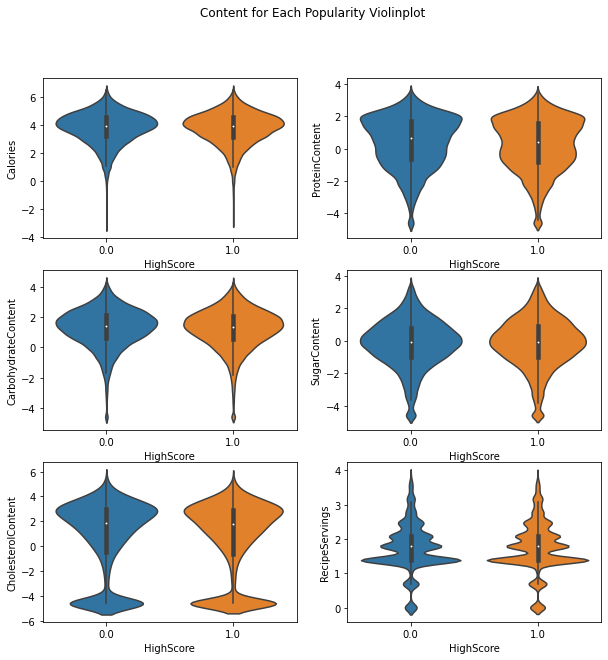

In [41]:
# Checking violinplot between HighScore, with the filtered df to prevent outlier
# We can't really seee significant difference
fig, ax = plt.subplots(3, 2, figsize=(10,10))
sns.violinplot("HighScore","Calories",data=log_df, ax=ax[0,0])
sns.violinplot("HighScore","ProteinContent",data=log_df, ax=ax[0,1])
sns.violinplot("HighScore","CarbohydrateContent",data=log_df, ax=ax[1,0])
sns.violinplot("HighScore","SugarContent",data=log_df, ax=ax[1,1])
sns.violinplot("HighScore","CholesterolContent",data=log_df, ax=ax[2,0]);
sns.violinplot("HighScore","RecipeServings",data=log_df, ax=ax[2,1])
plt.suptitle("Content for Each Popularity Violinplot");

Text(0.5, 0.98, 'Line Trend on Popularity vs Content')

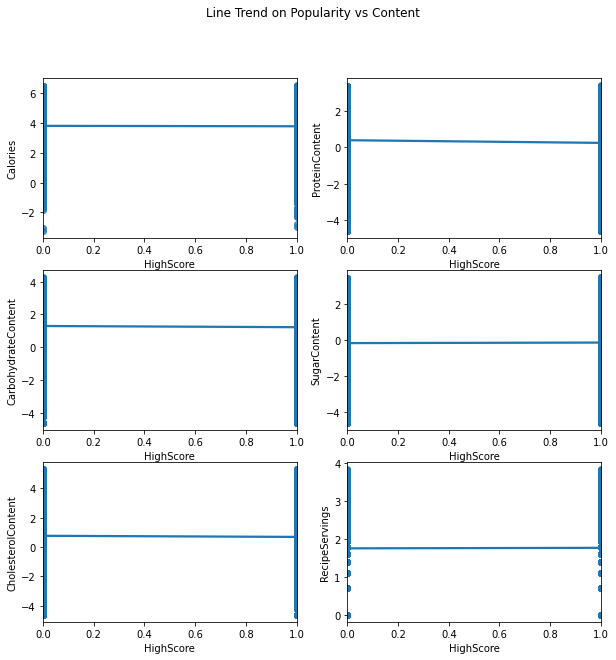

In [42]:
# Checking the fit line on ingredients vs HighScore
fig, ax = plt.subplots(3, 2, figsize=(10,10))
sns.regplot("HighScore","Calories",data=log_df, ax=ax[0,0])
sns.regplot("HighScore","ProteinContent",data=log_df, ax=ax[0,1])
sns.regplot("HighScore","CarbohydrateContent",data=log_df, ax=ax[1,0])
sns.regplot("HighScore","SugarContent",data=log_df, ax=ax[1,1])
sns.regplot("HighScore","CholesterolContent",data=log_df, ax=ax[2,0]);
sns.regplot("HighScore","RecipeServings",data=log_df, ax=ax[2,1]);

# We can't really see the trend line, we'll try another way
plt.suptitle("Line Trend on Popularity vs Content")

In [43]:
# We'll use other methods like ttest, to see if there are any relationship between ingredients and HighScore, with alpha = 0.05

print("Content vs HighScore relationship\n")
for i in df.iloc[:,1:-1].columns.tolist():
	xbar = df.groupby('HighScore')[i].mean()
	s = df.groupby('HighScore')[i].std()
	n = df.groupby('HighScore')[i].count()

	xbar_1 = xbar[1]
	xbar_0 = xbar[0]
	s_1 = s[1]
	s_0 = s[0]
	n_1 = n[1]
	n_0 = n[0]

	numerator = abs(- xbar_1 + xbar_0)
	denominator = np.sqrt(s_1 ** 2 / n_1 + s_0 ** 2 / n_0)
	t_stat = numerator / denominator
	dof = n_1 + n_0 - 2
	p = t.cdf(-t_stat,df=dof)+(1-t.cdf(t_stat, df=dof))
	if  p < 0.05:
		print(i,"significantly correlated")
	else:
		print(f"{i:<20}: unsignificantly correlated")
# Maybe one feature isn't enough to explain the target, we'll use model to see the multipe feature can explain the target

Content vs HighScore relationship

Calories            : unsignificantly correlated
CholesterolContent  : unsignificantly correlated
CarbohydrateContent : unsignificantly correlated
SugarContent        : unsignificantly correlated
ProteinContent      : unsignificantly correlated
RecipeServings      : unsignificantly correlated


In [44]:
# One hot encoder for the recipe category. Each category can affect the popularity
enc = OneHotEncoder(handle_unknown = 'ignore')
enc.fit(pd.DataFrame(log_df.RecipeCategory))

enc_df = pd.DataFrame(enc.transform(pd.DataFrame(log_df.RecipeCategory)).toarray())
log_df = pd.concat([log_df.drop("RecipeCategory",axis=1).reset_index(drop=True), enc_df], axis=1)

enc_df_test = pd.DataFrame(enc.transform(pd.DataFrame(log_df_test.RecipeCategory)).toarray())
log_df_test = pd.concat([log_df_test.drop("RecipeCategory",axis=1).reset_index(drop=True), enc_df_test], axis=1)

In [45]:
# Function to compare some classification model
def search_clf_model(X,y,score='accuracy'):
	models={'RFC':RandomForestClassifier(random_state=1),
        'AdaBoost':AdaBoostClassifier(random_state=1),
        'NaiveBayes':GaussianNB(),
        'GBC':GradientBoostingClassifier(random_state=1),
        'LogReg':LogisticRegression(random_state=1),
        'KNN':KNeighborsClassifier(),
        'XGB':XGBClassifier()}
 
	for mdl in models.keys():
		model=models[mdl]
		val_score=cross_val_score(model,X,y,scoring=score,cv=5)
		print(f'{mdl} {score}:',np.mean(val_score))

In [46]:
# For the evaluation metric, we used roc auc to tell how much the model is capable of distinguishing between classes

# search_clf_model(log_df.drop("HighScore", axis =1), log_df.HighScore, 'roc_auc')

# Roc Auc score prediction on different model
print('''RFC roc_auc: 0.5288749954886988
AdaBoost roc_auc: 0.5432151013795292
NaiveBayes roc_auc: 0.526123805972141
GBC roc_auc: 0.546487849945158
LogReg roc_auc: 0.5469819112370169
KNN roc_auc: 0.5169713033157014
XGB roc_auc: 0.546270896807789
''')
# The results show that gradient boosting model has a higher result, we'll try xgboost

RFC roc_auc: 0.5288749954886988
AdaBoost roc_auc: 0.5432151013795292
NaiveBayes roc_auc: 0.526123805972141
GBC roc_auc: 0.546487849945158
LogReg roc_auc: 0.5469819112370169
KNN roc_auc: 0.5169713033157014
XGB roc_auc: 0.546270896807789



In [47]:
# Function to hyperparameter tuning model
def tuning_model(model, X, y, score='f1', n_iter=50):
  models = {'XGB': XGBClassifier()}

  hyperparameter = {'XGB': {'learning_rate': [loguniform.rvs(1e-3,5e-1)], 										'max_depth': Integer(5,25), 
                            'min_child_weight': Integer(1,8),
                            'subsample': Real(0.4, 1), 
                            'colsample_bytree': Real(0.5, 0.7), 
                            'n_estimators' : Integer(40,160), 'random_state':[1],
                           	'eval_metric':['mlogloss'],
                           'scale_pos_weight':Real(35/65,65/35)}}

  for mdl in model:
    opt = BayesSearchCV(models[mdl], hyperparameter[mdl], n_iter=n_iter,
                        random_state=0, verbose=2, cv=5)
    opt.fit(X, y)
    print(f'{mdl} best score: {opt.best_score_}')
    print(f'{mdl} best params: {opt.best_params_}')
    
    val_score = cross_val_score(opt.best_estimator_ , X, y, scoring=score, cv=5)
    print(f'{mdl} {score}:', np.mean(val_score))

In [48]:
# tuning_model(['XGB'], log_df.drop(["HighScore"], axis =1), log_df.HighScore, n_iter = 10, score='roc_auc')

print('''
XGB best score: 0.553128439283048
XGB best params: OrderedDict([('colsample_bytree', 0.6020978092836968), ('eval_metric', 'mlogloss'), ('learning_rate', 0.17664481294630635), ('max_depth', 6), ('min_child_weight', 1), ('n_estimators', 69), ('random_state', 1), ('scale_pos_weight', 0.53846153846), ('subsample', 0.689876731859562)])
''')

# The parameter results after tuning model


XGB best score: 0.553128439283048
XGB best params: OrderedDict([('colsample_bytree', 0.6020978092836968), ('eval_metric', 'mlogloss'), ('learning_rate', 0.17664481294630635), ('max_depth', 6), ('min_child_weight', 1), ('n_estimators', 69), ('random_state', 1), ('scale_pos_weight', 0.53846153846), ('subsample', 0.689876731859562)])



In [49]:
# Fit model with the parameter that we've been searched before

xgb= XGBClassifier(colsample_bytree=0.6020978092836968, 
                   eval_metric= 'mlogloss', 															learning_rate=0.17664481294630635,
                   max_depth= 6, min_child_weight= 1, 
                   n_estimators= 69, random_state= 1,
                   subsample= 0.689876731859562,
                  scale_pos_weight=0.53846153846)
                         
xgb.fit(log_df.drop(["HighScore"], axis =1), log_df.HighScore, verbose=2)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6020978092836968,
              eval_metric='mlogloss', gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.17664481294630635, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=69, n_jobs=16, num_parallel_tree=1, random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.53846153846,
              subsample=0.689876731859562, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [50]:
# Calculate the sensitivity and specificity score with treshold 0.5
tn, fp, fn, tp = confusion_matrix(log_df_test.HighScore, 					 										 xgb.predict_proba(log_df_test.drop(["HighScore"], 
                                   axis=1))[:,1]>0.5).ravel()

sensitivity1 = tp/(tp+fn)
print('Sensitivity : ', sensitivity1 )

specificity1 = tn/(tn+fp)
print('Specificity : ', specificity1)

Sensitivity :  0.5122214234363767
Specificity :  0.5507531106745253


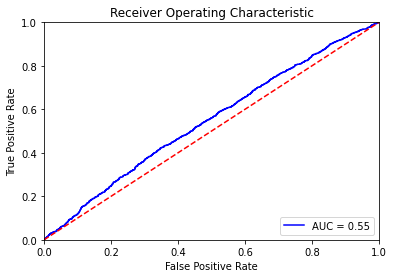

In [51]:
# Plot the roc curve and auc score
from sklearn import metrics
probs = xgb.predict_proba(log_df_test.drop(["HighScore"], 
                                   axis=1))
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(log_df_test.HighScore, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

# The model couldn't distinguish the classes well.

In [52]:
# We'll adjust the treshold to 0.55, because we'll focus in predicting correctly the unpopular recipe. Although the score is better in predicting unpopular recipe, the drawback shows that it's not too good in predicting popular recipe
tn, fp, fn, tp = confusion_matrix(log_df_test.HighScore, 					 										 xgb.predict_proba(log_df_test.drop(["HighScore"], 
                                   axis=1))[:,1]>0.55).ravel()

sensitivity1 = tp/(tp+fn)
print('Sensitivity : ', sensitivity1 )

specificity1 = tn/(tn+fp)
print('Specificity : ', specificity1)

Sensitivity :  0.2544931703810209
Specificity :  0.7969875573018992


In [53]:
# The predicted value proportition
pd.Series(xgb.predict_proba(log_df_test.drop(["HighScore"], 
                                   axis=1))[:,1]>0.55).astype(int).value_counts()

0    3291
1    1018
dtype: int64

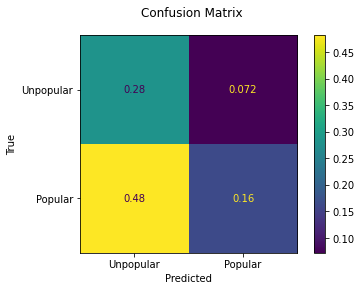

In [54]:
# Plot the confusion matrix
cm = confusion_matrix(log_df_test.HighScore, 					 										 xgb.predict_proba(log_df_test.drop(["HighScore"], 
                                   axis=1))[:,1]>0.55, 
                      normalize='all')
cmd = ConfusionMatrixDisplay(cm, display_labels=['Unpopular','Popular'])
cmd.plot()
cmd.ax_.set(xlabel='Predicted', ylabel='True')
plt.suptitle("Confusion Matrix");

# Conclusion & Recommendation
The following model shows that it receives 0.79 specificity. Although it's moderately high to predict the unpopular recipe correctly, the model can't distinguish the target well. It tends to be incorrect in predicting Popular Recipe (more on False Negative). Since the characteristic of each content and distribution with the popular and unpopular recipes are similar, it's hard to tell the model to differentiate them. 

Adding more content or features to the data is helpful to make the model recognize the feature better. Also, for every recipe that comes new, it needs filtering. Because some recipes are zero, whether in the content or calories, it is harder to tell what happened in the recipe and could create a bias. Some recipes also contain huge contents and calories with only one serving, leading to inaccurate predictions. 

Based on the analysis, the more popular recipe is when there are more calories, more sugar, moderate cholesterol, low protein, and not moderate carbohydrate. Also, the recipe that contains no sugar or no carbohydrate, or no protein receives more popularity than the average popularity among all recipes.

# Notebook Recommendation
- Could be added more feature engineering technique
- Used one of state of the art gradient boosting tree model (CatBoost)
- Used more complex model such as deep learning